In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

TorchVision Object Detection Finetuning Tutorial
================================================


Defining the Dataset
====================

The reference scripts for training object detection, instance
segmentation and person keypoint detection allows for easily supporting
adding new custom datasets. The dataset should inherit from the standard
`torch.utils.data.Dataset`{.interpreted-text role="class"} class, and
implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__`
should return a tuple:

-   image: `torchvision.tv_tensors.Image`{.interpreted-text
    role="class"} of shape `[3, H, W]`, a pure tensor, or a PIL Image of
    size `(H, W)`
-   target: a dict containing the following fields
    -   `boxes`,
        `torchvision.tv_tensors.BoundingBoxes`{.interpreted-text
        role="class"} of shape `[N, 4]`: the coordinates of the `N`
        bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to
        `W` and `0` to `H`
    -   `labels`, integer `torch.Tensor`{.interpreted-text role="class"}
        of shape `[N]`: the label for each bounding box. `0` represents
        always the background class.
    -   `image_id`, int: an image identifier. It should be unique
        between all the images in the dataset, and is used during
        evaluation
    -   `area`, float `torch.Tensor`{.interpreted-text role="class"} of
        shape `[N]`: the area of the bounding box. This is used during
        evaluation with the COCO metric, to separate the metric scores
        between small, medium and large boxes.
    -   `iscrowd`, uint8 `torch.Tensor`{.interpreted-text role="class"}
        of shape `[N]`: instances with `iscrowd=True` will be ignored
        during evaluation.
    -   (optionally) `masks`,
        `torchvision.tv_tensors.Mask`{.interpreted-text role="class"} of
        shape `[N, H, W]`: the segmentation masks for each one of the
        objects

If your dataset is compliant with above requirements then it will work
for both training and evaluation codes from the reference script.
Evaluation code will use scripts from `pycocotools` which can be
installed with `pip install pycocotools`.

One note on the `labels`. The model considers class `0` as background.
If your dataset does not contain the background class, you should not
have `0` in your `labels`. For example, assuming you have just two
classes, *cat* and *dog*, you can define `1` (not `0`) to represent
*cats* and `2` to represent *dogs*. So, for instance, if one of the
images has both classes, your `labels` tensor should look like `[1, 2]`.

Additionally, if you want to use aspect ratio grouping during training
(so that each batch only contains images with similar aspect ratios),
then it is recommended to also implement a `get_height_and_width`
method, which returns the height and the width of the image. If this
method is not provided, we query all elements of the dataset via
`__getitem__` , which loads the image in memory and is slower than if a
custom method is provided.

So each image has a corresponding segmentation mask, where each color
correspond to a different instance. Let's write a
`torch.utils.data.Dataset`{.interpreted-text role="class"} class for
this dataset. In the code below, we are wrapping images, bounding boxes
and masks into `torchvision.tv_tensors.TVTensor`{.interpreted-text
role="class"} classes so that we will be able to apply torchvision
built-in transformations ([new Transforms
API](https://pytorch.org/vision/stable/transforms.html)) for the given
object detection and segmentation task. Namely, image tensors will be
wrapped by `torchvision.tv_tensors.Image`{.interpreted-text
role="class"}, bounding boxes into
`torchvision.tv_tensors.BoundingBoxes`{.interpreted-text role="class"}
and masks into `torchvision.tv_tensors.Mask`{.interpreted-text
role="class"}. As `torchvision.tv_tensors.TVTensor`{.interpreted-text
role="class"} are `torch.Tensor`{.interpreted-text role="class"}
subclasses, wrapped objects are also tensors and inherit the plain
`torch.Tensor`{.interpreted-text role="class"} API. For more information
about torchvision `tv_tensors` see [this
documentation](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors).


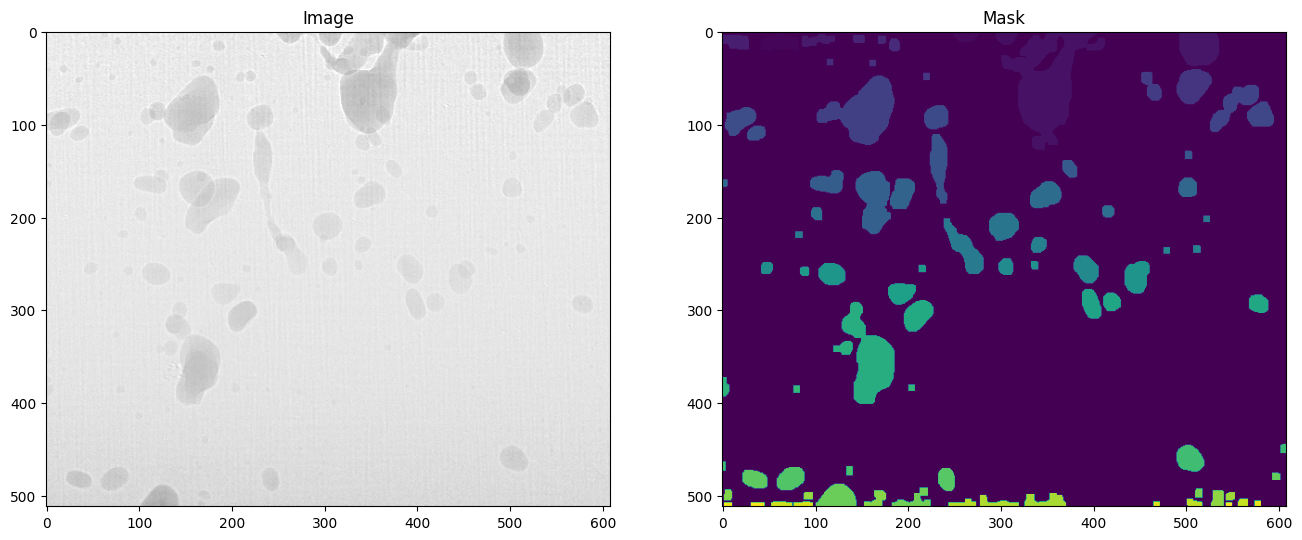

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import cv2
import torch 

def tif_to_CHW(filepath):
    """Reads in a .tif file as a color image in the cv2 hwc format and converts to 
    the torch chw format"""

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    return image


image = cv2.imread("Processed Data/train/IMGs/000142.png")
mask = read_image("Processed Data/train/masks/000142.png")
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image)
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [3]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as FTV


class MPFDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, 'IMGs'))))
        self.masks = list(sorted(os.listdir(os.path.join(self.root, 'masks'))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(os.path.join(self.root, 'IMGs'), self.imgs[idx])
        mask_path = os.path.join(os.path.join(self.root, 'masks'), self.masks[idx])
        

        img = read_image(img_path)
        
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        # TODO: what if we eventually have more than 1 class?
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=FTV.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchsummary import summary

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights = None, 
                                                               progress=True, 
                                                               num_classes=2,
                                                               weights_backbone = None, 
                                                               trainable_backbone_layers=5)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 4096
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model

That's it, this will make `model` be ready to be trained and evaluated
on your custom dataset.

Putting everything together
===========================

In `references/detection/`, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
`references/detection/engine.py` and `references/detection/utils.py`.
Just download everything under `references/detection` to your folder and
use them here. On Linux if you have `wget`, you can download them using
below commands:


In [5]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

1

Since v0.15.0 torchvision provides [new Transforms
API](https://pytorch.org/vision/stable/transforms.html) to easily write
data augmentation pipelines for Object Detection and Segmentation tasks.

Let's write some helper functions for data augmentation /
transformation:


In [6]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    # if train:
        # transforms.append(T.GaussianBlur())
        # transforms.append(T.RandomVerticalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

Testing `forward()` method (Optional)
=====================================

Before iterating over the dataset, it\'s good to see what the model
expects during training and inference time on sample data.


In [7]:
import utils
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = MPFDataset('Processed Data/train', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions)

{'loss_classifier': tensor(1.6801, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2081, grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.8617, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1060, grad_fn=<DivBackward0>)}
[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


Let's now write the main function which performs the training and the
validation:


Cuda: True
dict_keys(['boxes', 'masks', 'labels', 'image_id', 'area', 'iscrowd'])
torch.Size([30, 4])
torch.Size([30, 389, 389])


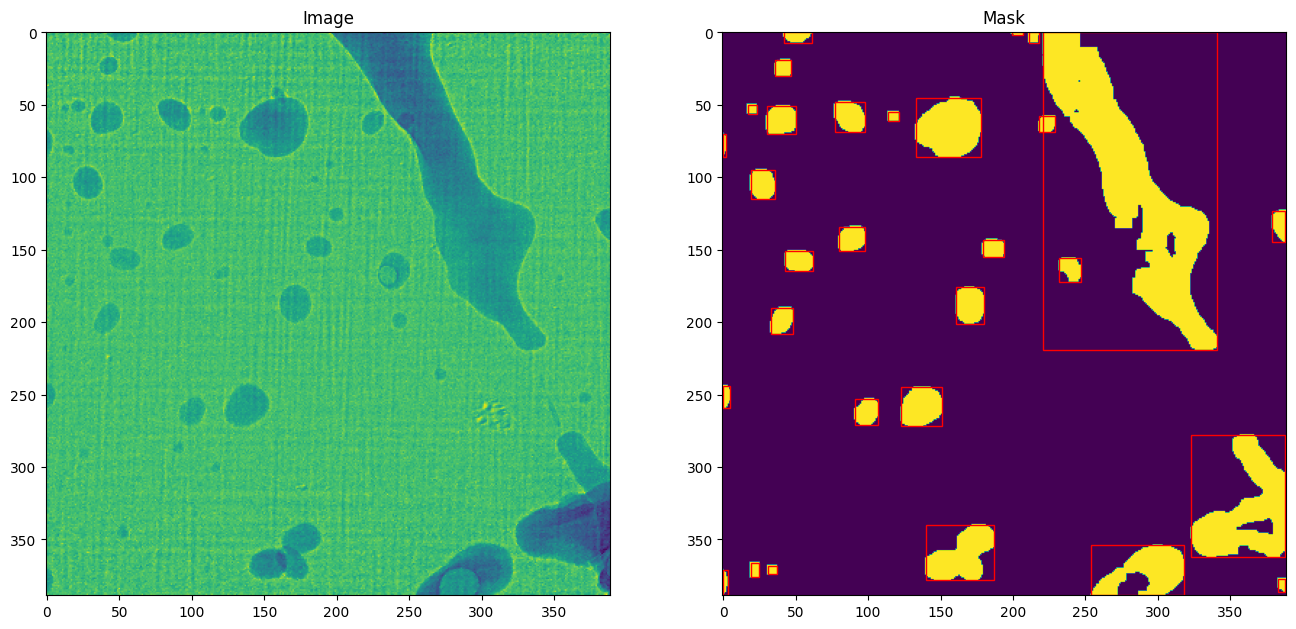

In [8]:
from engine import train_one_epoch, evaluate
import matplotlib.patches as patches

# train on the GPU or on the CPU, if a GPU is not available
print(f'Cuda: {torch.cuda.is_available()}')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
train = MPFDataset('Processed Data/train', get_transform(train=True))
test = MPFDataset('Processed Data/test', get_transform(train=False))



img, targ = dataset.__getitem__(52)
print(targ.keys())
print(targ['boxes'].shape)
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(img.squeeze(0))
ax = plt.subplot(122)
plt.title("Mask")
print(targ['masks'].shape)
plt.imshow(torch.sum(targ['masks'], dim=0))
for rect in targ['boxes']:
        x1, y1, x2, y2 = rect
        width = x2 - x1
        height = y2 - y1
        rect_patch = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect_patch)

In [9]:
# define training and validation data loaders
train_data_loader = torch.utils.data.DataLoader(
    train,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

test_data_loader = torch.utils.data.DataLoader(
    test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
print(len([p for p in model.parameters()]))
for p in model.parameters():
    p.requires_grad = True
params = [p for p in model.parameters() if p.requires_grad]
print(len(params))

# move model to the right device
model.to(device)

# construct an optimizer

optimizer = torch.optim.SGD(
    params,
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 8

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)



c:\Users\jfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\detection\backbone_utils.py:162: UserWarning: Changing trainable_backbone_layers has no effect if neither pretrained nor pretrained_backbone have been set to True, falling back to trainable_backbone_layers=5 so that all layers are trainable
  warnings.warn(


225
225
Epoch: [0]  [   0/3845]  eta: 4:21:21  lr: 0.000020  loss: 8.9753 (8.9753)  loss_classifier: 0.7190 (0.7190)  loss_box_reg: 0.0672 (0.0672)  loss_mask: 7.4576 (7.4576)  loss_objectness: 0.6918 (0.6918)  loss_rpn_box_reg: 0.0397 (0.0397)  time: 4.0784  data: 0.0245  max mem: 4338
Epoch: [0]  [  10/3845]  eta: 11:59:50  lr: 0.000120  loss: 8.3593 (7.9701)  loss_classifier: 0.7183 (0.7187)  loss_box_reg: 0.1457 (0.1513)  loss_mask: 6.1185 (5.8849)  loss_objectness: 0.6921 (0.6921)  loss_rpn_box_reg: 0.5109 (0.5230)  time: 11.2623  data: 0.1495  max mem: 12016


AssertionError: All bounding boxes should have positive height and width. Found invalid box [39.83402633666992, 0.0, 59.75103759765625, 0.0] for target at index 0.

So after one epoch of training, we obtain a COCO-style mAP \> 50, and a
mask mAP of 65.

But what do the predictions look like? Let's take one image in the
dataset and verify


tensor(0.7686)


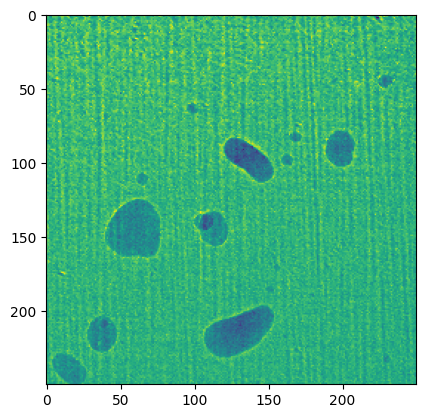

dict_keys(['boxes', 'labels', 'scores', 'masks'])
torch.Size([1, 250, 250])
len(pred["boxes"])=100


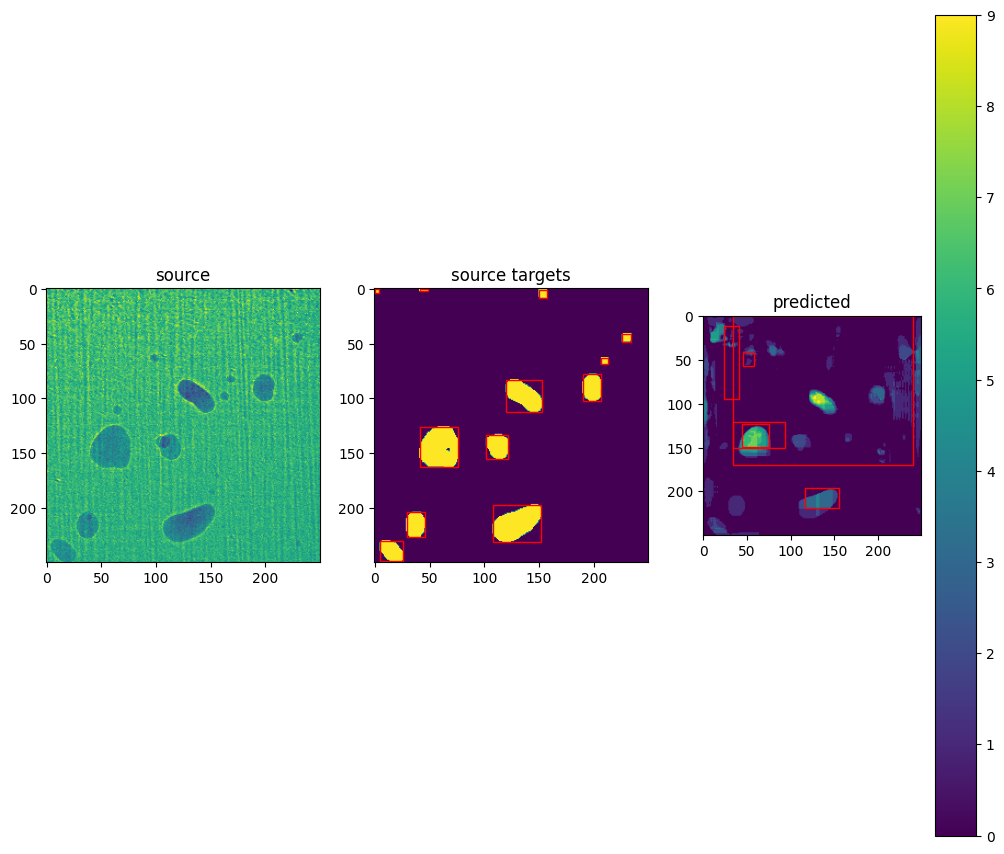

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import numpy as np

image, targ = test.__getitem__(np.random.randint(0,50))
# cv2.imshow('temp', torch.Tensor.numpy(image.reshape(512,608,3)))
# cv2.waitKey(0)
# cv2.destroyAllWindows
# image = image.repeat(, 1, 1)
eval_transform = get_transform(train=False)
print(torch.min(image))

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    plt.imshow(x.squeeze(0))
    plt.show()
    x = x.to(device)
    
    predictions = model([x])
    pred = predictions[0]
    print(pred.keys())


# image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
# image = image.reshape(512,608,3)
# image = image[:3, ...]
print(image.shape)
# pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_boxes = pred["boxes"].long()
# output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# output_image = draw_segmentation_masks(image, masks, alpha=0.5, colors="blue")

masks = (pred['masks'] > 0.5)
print(f'{len(pred["boxes"])=}')

fig, ax = plt.subplots(ncols = 3)
fig.set_figwidth(12)
fig.set_figheight(6)
ax[0].imshow(image.squeeze(0))
ax[0].set_title('source')
ax[1].set_title('source targets')
ax[1].imshow(torch.sum(targ['masks'], dim=0))
for rect in targ['boxes']:
        x1, y1, x2, y2 = rect
        width = x2 - x1
        height = y2 - y1
        rect_patch = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect_patch)
im = ax[2].imshow(torch.Tensor.cpu(torch.sum(masks, dim = 0).squeeze(0)))
ax[2].set_title('predicted')
for i in range(len(pred['boxes'])):
        if pred['scores'][i] > 0.65:
            rect = pred['boxes'][i]
            x1, y1, x2, y2 = torch.Tensor.cpu(rect)
            width = x2 - x1
            height = y2 - y1
            rect_patch = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax[2].add_patch(rect_patch)
fig.colorbar(im, ax=ax[2])


The results look good!

Wrapping up
===========

In this tutorial, you have learned how to create your own training
pipeline for object detection models on a custom dataset. For that, you
wrote a `torch.utils.data.Dataset`{.interpreted-text role="class"} class
that returns the images and the ground truth boxes and segmentation
masks. You also leveraged a Mask R-CNN model pre-trained on COCO
train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU
training, check `references/detection/train.py`, which is present in the
torchvision repository.


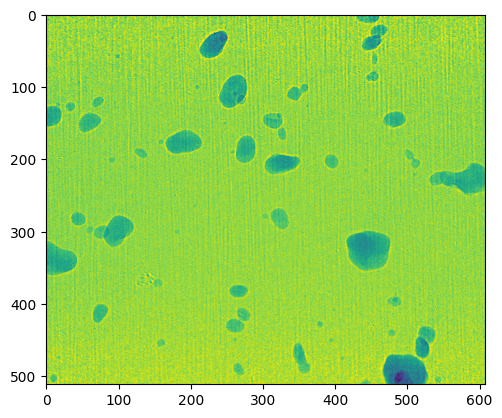

dict_keys(['boxes', 'labels', 'scores', 'masks'])
(512, 608)


Text(0.5, 1.0, 'predicted')

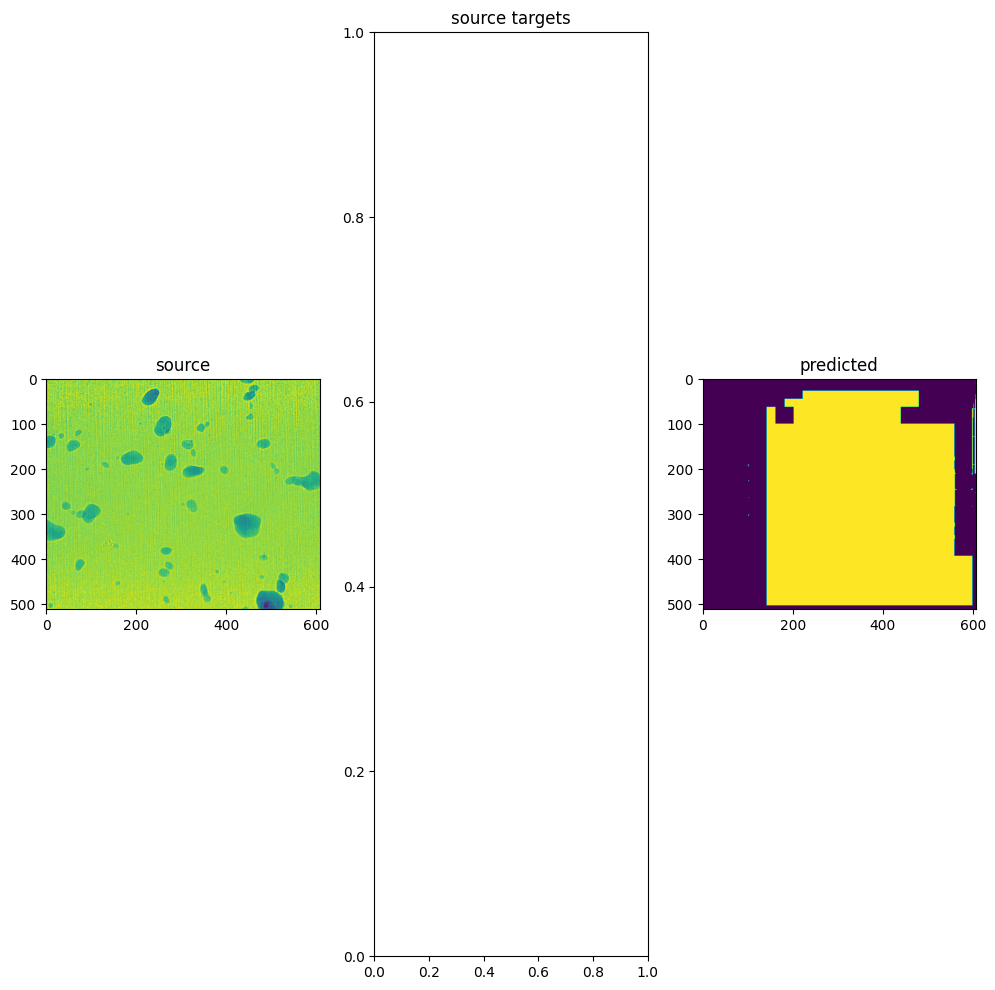

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import numpy as np

# image, targ = train.__getitem__(np.random.randint(0,50))
t = get_transform(False)
image = tif_to_CHW("Data\\Processed data for 512_608_x=-2.08_y=31.2_Ql=0.099_Qg=75_Qsw=75_fps=6000\\512_608_x=-2.08_y=31.2_Ql=0.099_Qg=75_Qsw=75_fps=6000_006600.tif")

# cv2.imshow('temp', torch.Tensor.numpy(image.reshape(512,608,3)))
# cv2.waitKey(0)
# cv2.destroyAllWindows
# image = image.repeat(, 1, 1)
eval_transform = get_transform(train=False)
# print(torch.min(image))

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    plt.imshow(x)
    plt.show()
    x = torch.Tensor(x).unsqueeze(0)
    x = x.to(device)
    
    predictions = model([x])
    pred = predictions[0]
    print(pred.keys())


# image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
# image = image.reshape(512,608,3)
# image = image[:3, ...]
print(image.shape)
# pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_boxes = pred["boxes"].long()
# output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# output_image = draw_segmentation_masks(image, masks, alpha=0.5, colors="blue")

masks = (pred['masks'] >= 1)

fig, ax = plt.subplots(ncols = 3)
fig.set_figwidth(12)
fig.set_figheight(12)
ax[0].imshow(image)
ax[0].set_title('source')
ax[1].set_title('source targets')
# ax[1].imshow(torch.sum(targ['masks'], dim=0))
# for rect in targ['boxes']:
#         x1, y1, x2, y2 = rect
#         width = x2 - x1
#         height = y2 - y1
#         rect_patch = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
#         ax[1].add_patch(rect_patch)
ax[2].imshow(torch.Tensor.cpu(torch.sum(masks, dim = 0).squeeze(0)>0))
ax[2].set_title('predicted')
# for rect in pred['boxes']:
#         x1, y1, x2, y2 = torch.Tensor.cpu(rect)
#         width = x2 - x1
#         height = y2 - y1
#         rect_patch = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
#         ax[2].add_patch(rect_patch)